In [1]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

# 컨볼루션 신경망을 사용한 텍스쳐 합성

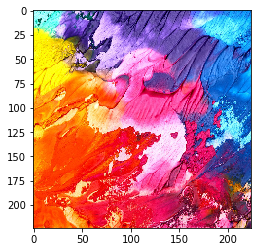

In [3]:
# 8.42 원본 텍스쳐 이미지 불러오기
import matplotlib.pyplot as plt
import cv2

style_path = tf.keras.utils.get_file('style.jpg', 'http://bit.ly/2mGfZIq')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0
plt.imshow(style_image)

tf.Tensor([0.31099403 0.3471651  0.93846714], shape=(3,), dtype=float32)


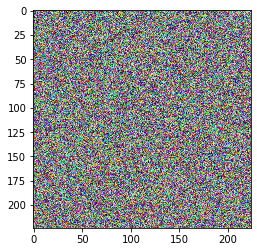

In [4]:
# 8.43 타겟 텍스쳐 만들기
target_image = tf.random.uniform(style_image.shape)
print(target_image[0,0,:])
plt.imshow(target_image)

In [5]:
# 8.44 VGG-19 네트워크 불러오기
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 12s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [5]:
# 8.45 특징 추출 모델 만들기
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [6]:
# 8.46 Gram matrix 계산 함수 정의
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [7]:
# 8.47 원본 텍스쳐에서 gram matrix 계산
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch * 255.0))

(1, 224, 224, 64)


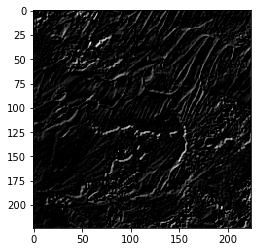

In [8]:
# 8.48 원본 텍스쳐의 첫번째 특징 추출값 확인
print(style_output[0].shape)
plt.imshow(tf.squeeze(style_output[0][:,:,:,0], 0), cmap='gray')

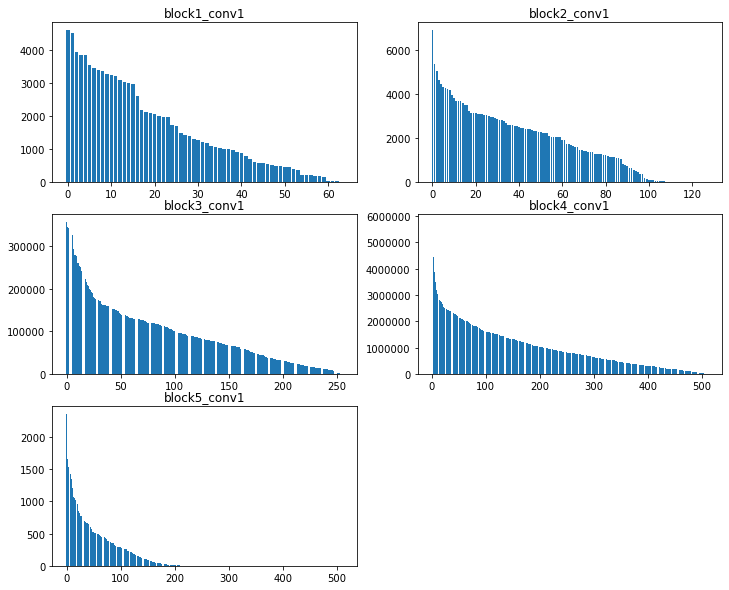

In [9]:
# 8.49 원본 텍스쳐의 gram matrix 계산값 만들기, 분포 확인
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize=(12,10))
for c in range(5):
    plt.subplot(3,2,c+1)
    array = sorted(style_outputs[c].numpy()[0].tolist())
    array = array[::-1]
    plt.bar(range(style_outputs[c].shape[0]), array)
    plt.title(style_layers[c])
plt.show()

In [10]:
# 8.50 타겟 텍스쳐를 업데이트하기 위한 함수 정의
def get_outputs(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model(preprocess_input(image_batch * 255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs
  
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])
  
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [11]:
# 8.51 tf.function과 GradientTape을 이용한 이미지 업데이트 함수 정의
opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

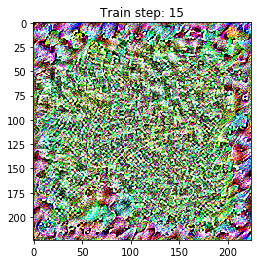

Total time: 50.7


In [12]:
# 8.52 텍스쳐 합성 알고리즘 실행
import IPython.display as display
import time
import imageio

start = time.time()

image = tf.Variable(target_image)

epochs = 3#50
steps_per_epoch = 5#100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [13]:
# 8.53 varitation loss 함수 정의
def high_pass_x_y(image):
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [14]:
# 8.54 variation loss 비교
print('target   :', total_variation_loss(image.read_value()))
print('noise    :', total_variation_loss(tf.random.uniform(style_image.shape)))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.27776486, shape=(), dtype=float32)
noise    : tf.Tensor(0.3342136, shape=(), dtype=float32)
original : tf.Tensor(0.03641251305469576, shape=(), dtype=float64)


In [15]:
# 8.55 variation loss를 loss 계산식에 추가, 각 loss의 가중치 추가
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

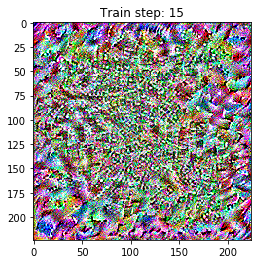

Total time: 53.5


In [16]:
# 8.56 variation loss를 추가한 텍스쳐 합성 알고리즘 실행
start = time.time()

target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 3 # 50
steps_per_epoch =5 #100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_variation_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [17]:
# 8.57 원본과 타겟의 variation loss 비교
print('target   :', total_variation_loss(image.read_value()))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.27843967, shape=(), dtype=float32)
original : tf.Tensor(0.03641251305469576, shape=(), dtype=float64)


# 컨볼루션 신경망을 사용한 Style Transfer (Neural Style Transfer)

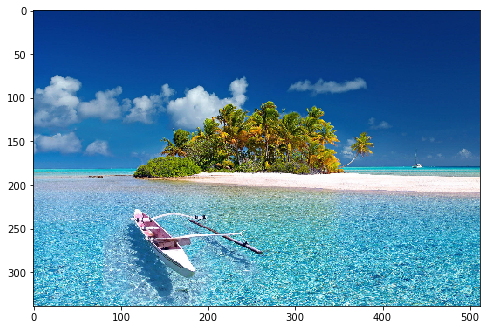

In [18]:
# 8.58 content 텍스쳐 불러오기
import matplotlib.pyplot as plt
import cv2

content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')

content_image = plt.imread(content_path)
max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize=(new_width, new_height))
content_image = content_image / 255.0
plt.figure(figsize=(8,8))
plt.imshow(content_image)

In [19]:
# 8.59 content 특징 추출 모델 만들기
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis=0)

content_layers = ['block5_conv2']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

In [20]:
# 8.60 content output, loss 함수 정의
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

In [21]:
# 8.61 content loss를 loss 계산식에 추가
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

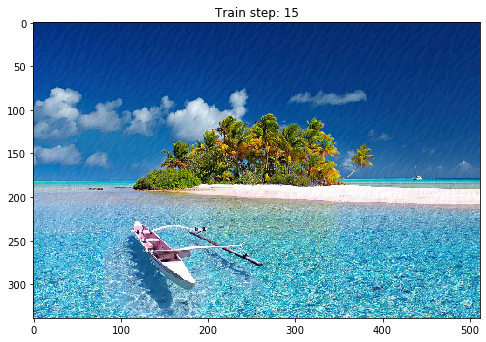

Total time: 238.0


In [22]:
# 8.62 Neural Style Transfer 실행
start = time.time()

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 5#20
steps_per_epoch = 3#100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
# 그림 8.24 출력 코드
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch * 255.0))

plt.figure(figsize=(16,16))

for c in range(style_output[0].shape[-1]):
    plt.subplot(8,8,c+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(style_output[0][:,:,:,c], 0), cmap='gray')